# Transformer - Neural Machine Translation

### Connect to Colab

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

In [ ]:
%cd /gdrive/My Drive/Google Colab/Transformers/00 - Attention Is All You Need

/gdrive/My Drive/Google Colab/Transformers/00 - Attention Is All You Need


### Import libraries

In [ ]:
!pip install tensorflow==2.11.0
import tensorflow as tf
import numpy as np
import os
import shutil
import random
import glob
import warnings
import logging
import string
import re
import matplotlib.pyplot as plt
plt.rc('font', size=16) 

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2.9.2


### Set seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Suppress warnings

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### Load and process data

Dataset source: http://www.manythings.org/anki/

In [ ]:
!head -42 ita.txt

Hi.	Ciao!	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #607364 (Cero)
Hi.	Ciao.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #4522287 (Guybrush88)
Run!	Corri!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906347 (Guybrush88)
Run!	Corra!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906348 (Guybrush88)
Run!	Correte!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906350 (Guybrush88)
Who?	Chi?	CC-BY 2.0 (France) Attribution: tatoeba.org #2083030 (CK) & #2126402 (Guybrush88)
Wow!	Wow!	CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #1922050 (Guybrush88)
Duck!	Amore!	CC-BY 2.0 (France) Attribution: tatoeba.org #280158 (CM) & #5502518 (Guybrush88)
Duck!	Tesoro!	CC-BY 2.0 (France) Attribution: tatoeba.org #280158 (CM) & #5502519 (Guybrush88)
Duck!	Immergiti!	CC-BY 2.0 (France) Attribution: tatoeba.org #280158 (CM) & #5502520 (Guybrush88)
Duck!	Si immerga!	CC-BY 2.0 (France) Attribution: tatoeba

In [ ]:
def read_txt(txt_file):
    # create an empty list to store sentences
    sentences = []
    # loop through each line in the txt file
    for line in open(txt_file, encoding='utf-8'):
        # check if line contains a tab character
        if '\t' not in line:  
            # if not, skip to the next line
            continue
        # split the line by tab character and assign the resulting parts to variables
        eng_sentence, ita_sentence, _ = line.rstrip().split('\t')
        # append the sentences to the list with start and end tokens added
        sentences.append([eng_sentence,"[start] " + ita_sentence + " [end]"])
    # return the list of sentences
    return sentences

In [ ]:
# Get english-italian sentence pairs
text_pairs = read_txt('ita.txt')

# Print some pair example
for _ in range(5):
    print(random.choice(text_pairs))

["Do you still have a key to Tom's apartment?", "[start] Voi avete ancora una chiave dell'appartamento di Tom? [end]"]
['Are they still mad?', '[start] Loro sono ancora arrabbiate? [end]']
['I like to eat.', '[start] A me piace mangiare. [end]']
['Tom did nothing but cry.', '[start] Tom non fece altro che piangere. [end]']
['Tom gave me some money.', "[start] Tom mi diede un po' di soldi. [end]"]


In [ ]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

358373 total pairs
250863 training pairs
53755 validation pairs
53755 test pairs


In [ ]:
# Define a list of characters to strip from input text
strip_chars = string.punctuation + "¿"

# Remove "[" and "]" from the list of stripped characters
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

# Vocab size and sequence length for vectorization
vocab_size = 20000
sequence_length = 32
batch_size = 256

def custom_standardization(input_string):
    """
    Custom function to standardize input text.
    Convert input string to lowercase and remove special characters.
    """
    # convert input string to lowercase
    lowercase = tf.strings.lower(input_string)
    # replace special characters with empty string
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

# Initialize vectorization for English and Italian
eng_vectorization = tfkl.TextVectorization(
    max_tokens=vocab_size, 
    output_mode="int", 
    output_sequence_length=sequence_length,
)
ita_vectorization = tfkl.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)

# Adapt vectorization to training texts
train_eng_texts = [pair[0] for pair in train_pairs]
train_ita_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts)
ita_vectorization.adapt(train_ita_texts)

In [ ]:
def format_dataset(eng, ita):
    # Vectorize the english and italian text
    eng = eng_vectorization(eng)
    ita = ita_vectorization(ita)
    # Return a tuple of the encoded inputs and decoder inputs, with the decoder inputs being the italian text shifted by 1
    return ({"encoder_inputs": eng, "decoder_inputs": ita[:, :-1],}, ita[:, 1:])

def make_dataset(pairs):
    # Unzip the pairs of english and italian text
    eng_texts, ita_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    ita_texts = list(ita_texts)
    # Create a dataset from the texts
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, ita_texts))
    # Batch the data
    dataset = dataset.batch(batch_size)
    # Apply the format_dataset function to the data
    dataset = dataset.map(format_dataset)
    # Shuffle the data, prefetch the next batch and cache the data 
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [ ]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (256, 32)
inputs["decoder_inputs"].shape: (256, 32)
targets.shape: (256, 32)


### Transformer

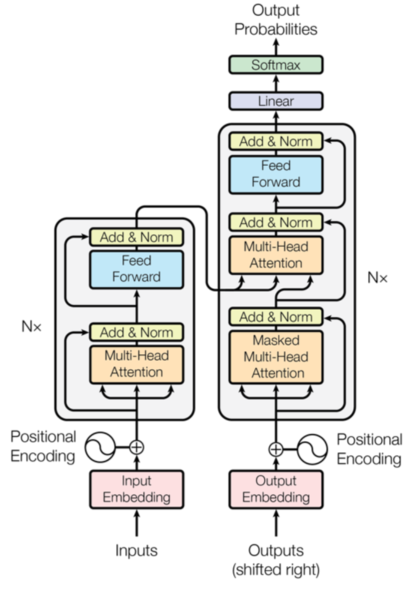

In [ ]:
class TokenAndPositionEmbedding(tfkl.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        # Embedding layer for the token
        self.token_emb = tfkl.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        # Embedding layer for the position
        self.pos_emb = tfkl.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        # Find the maximum length of the input
        maxlen = tf.shape(x)[-1]
        # Create a tensor with positions from 0 to maxlen-1
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # Embed the positions
        positions = self.pos_emb(positions)
        # Embed the tokens
        x = self.token_emb(x)
        # Add the token and position embeddings
        return x + positions

In [ ]:
class TransformerEncoderBlock(tfkl.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.att = tfkl.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tfk.Sequential(
            [
                tfkl.Dense(ff_dim, activation="relu"), 
                tfkl.Dense(embed_dim)
            ]
        )
        self.layernorm1 = tfkl.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tfkl.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tfkl.Dropout(rate)
        self.dropout2 = tfkl.Dropout(rate)
        
    def call(self, inputs, training):
        # Self-attention
        attn_output = self.att(inputs, inputs)
        # Apply dropout to the attention output
        attn_output = self.dropout1(attn_output, training=training)
        # Add the attention output to the input and normalize
        out1 = self.layernorm1(inputs + attn_output)
        # Feed-forward
        ffn_output = self.ffn(out1)
        # Apply dropout to the feed-forward output
        ffn_output = self.dropout2(ffn_output, training=training)
        # Add the feed-forward output to the previous output and normalize
        return self.layernorm2(out1 + ffn_output)

In [ ]:
class TransformerDecoderBlock(tfkl.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.att1 = tfkl.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.att2 = tfkl.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tfk.Sequential(
            [
                tfkl.Dense(ff_dim, activation="relu"), 
                tfkl.Dense(embed_dim)
            ]
        )
        self.layernorm1 = tfkl.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tfkl.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tfkl.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tfkl.Dropout(rate)
        self.dropout2 = tfkl.Dropout(rate)
        self.dropout3 = tfkl.Dropout(rate)
        
        
def call(self, inputs, encoder_outputs, training, mask=None):
        # Create a causal attention mask for the inputs
        causal_mask = self.get_causal_attention_mask(inputs)
        
        # If a padding mask is passed, combine it with the causal mask
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        else:
            padding_mask = None
        
        # Apply self-attention using the causal mask
        attn_output_1 = self.att1(
            query=inputs, 
            value=inputs, 
            key=inputs, 
            attention_mask=causal_mask
        )
        
        # Apply dropout
        attn_output_1 = self.dropout1(attn_output_1, training=training)
        
        # Apply layer normalization
        out_1 = self.layernorm1(inputs + attn_output_1)
        
        # Apply attention using the padding mask
        attn_output_2 = self.att2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask
        )
        
        # Apply dropout
        attn_output_2 = self.dropout2(attn_output_2, training=training)
        
        # Apply layer normalization
        out_2 = self.layernorm2(out_1 + attn_output_2)

        # Apply feed forward neural network
        ffn_output = self.ffn(out_2)

        # Apply dropout
        ffn_output = self.dropout3(ffn_output, training=training)

        # Apply layer normalization
        return self.layernorm3(out_2 + ffn_output)
        
def get_causal_attention_mask(self, inputs):
        """
        This function creates a lower triangular attention mask for use in a causal attention mechanism. 
        The attention mask is used to prevent the model from attending to future timesteps when processing a sequence, 
        ensuring that the model's predictions are based only on previous timesteps. 
        The function takes in an input tensor and returns a tensor of the same shape with a lower triangular mask applied, 
        where the lower triangular part is set to 1 and the upper triangular part is set to 0. 
        This mask is tiled to match the batch size and sequence length of the input tensor.
        """
        # Get the shape of the input tensor
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        # Create a range of sequence length
        i = tf.range(sequence_length)[:, tf.newaxis] # Transposition
        j = tf.range(sequence_length)
        # create a lower triangular mask
        mask = tf.cast(i >= j, dtype="int32")
        # reshape the mask
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1])) # low triangular matrix
        # concatenate the batch size and reshape the mask
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        # tile the mask
        return tf.tile(mask, mult)

In [ ]:
# Embedding size for each token
embed_dim = 128
# Dimention of the latent space
latent_dim = 1024
# Number of attention heads
num_heads = 4

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_inputs (InputLayer)  [(None, None)]           0         
                                                                 
 token_and_position_embeddin  (None, None, 128)        2564096   
 g_11 (TokenAndPositionEmbed                                     
 ding)                                                           
                                                                 
 transformer_encoder_block_2  (None, None, 128)        527616    
  (TransformerEncoderBlock)                                      
                                                                 
Total params: 3,091,712
Trainable params: 3,091,712
Non-trainable params: 0
_________________________________________________________________


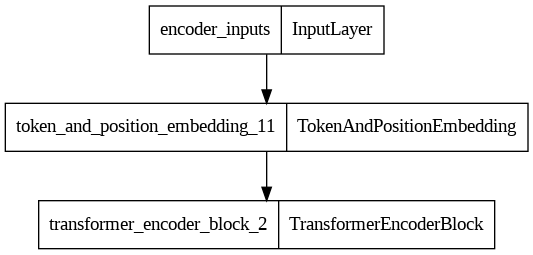

In [ ]:
encoder_inputs = tfk.Input(shape=(None,), dtype="int64", name="encoder_inputs")
# Adding token and position embedding layer
x = TokenAndPositionEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
# Adding transformer encoder block
encoder_outputs = TransformerEncoderBlock(embed_dim, num_heads, latent_dim)(x)
# Defining the encoder model
encoder = tfk.Model(encoder_inputs, encoder_outputs)
# Print the summary of the encoder model
encoder.summary()
# Visualize the encoder model
tfk.utils.plot_model(encoder)

In [ ]:
decoder_inputs = tfk.Input(shape=(None,), dtype="int64", name="decoder_inputs")
# Input for the encoded sequence from the encoder
encoded_seq_inputs = tfk.Input(shape=(None, embed_dim), name="decoder_state_inputs")
# Adding token and position embedding layer
x = TokenAndPositionEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
# Adding transformer decoder block, passing the encoded sequence inputs
x = TransformerDecoderBlock(embed_dim, num_heads, latent_dim)(x, encoded_seq_inputs)
# Apply dropout
x = tfkl.Dropout(0.5)(x)
# Apply dense layer with softmax activation
decoder_outputs = tfkl.Dense(vocab_size, activation="softmax")(x)
# Defining the decoder model
decoder = tfk.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)
# Print the summary of the decoder model
decoder.summary()
# Visualize the decoder model
tfk.utils.plot_model(decoder)

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 token_and_position_embedding_1  (None, None, 128)   2564096     ['decoder_inputs[0][0]']         
 2 (TokenAndPositionEmbedding)                                                                    
                                                                                                  
 decoder_state_inputs (InputLay  [(None, None, 128)]  0          []                               
 er)                                                                                              
                                                                                           

ValueError: ignored

In [ ]:
# Pass the decoder inputs and encoder outputs to the decoder
decoder_outputs = decoder([decoder_inputs, encoder_outputs])
# Defining the transformer model
transformer = tfk.Model([encoder_inputs, decoder_inputs], decoder_outputs, name="transformer")
# Print the summary of the transformer model
transformer.summary()
# Visualize the transformer model with nested models expanded
tfk.utils.plot_model(transformer, expand_nested=True)

In [ ]:
learning_rate = 1e-4
optimizer = tfk.optimizers.Adam(learning_rate)
loss = tfk.losses.SparseCategoricalCrossentropy()
metrics = ["accuracy"]

transformer.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
EPOCHS = 50

history = transformer.fit(
    train_ds, 
    epochs=EPOCHS, 
    validation_data=val_ds,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)
    ]
)

In [ ]:
best_epoch = np.argmax(history.history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history.history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history.history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Sparse Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history.history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history.history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
transformer.save('TransformerNMT')

In [ ]:
loaded_transformer = tfk.models.load_model('TransformerNMT')

In [ ]:
ita_vocab = ita_vectorization.get_vocabulary()
ita_index_lookup = dict(zip(range(len(ita_vocab)), ita_vocab))
max_decoded_sentence_length = 32


def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = ita_vectorization([decoded_sentence])[:, :-1]
        predictions = loaded_transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = ita_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence


test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(30):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence)
    print(input_sentence+" --> "+translated)